# Model And Testing
Group 17: Zijun Fu (zf2342), Xiaoyu Fang (xf2282), Ruoshi Zhang (rz2699), and Ruyue Zhang (rz2729)

## import packages

In [1]:
import pandas as pd
import numpy as np
import requests
from datetime import datetime
import statsmodels.api as sm
import matplotlib.pyplot as plt
from sklearn.linear_model import LinearRegression
from sklearn.model_selection import train_test_split
from sklearn.model_selection import KFold
from sklearn.metrics import mean_squared_error, r2_score
from sklearn.preprocessing import PolynomialFeatures
from sklearn.ensemble import GradientBoostingRegressor
from sklearn.model_selection import GridSearchCV
from sklearn.pipeline import make_pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.svm import SVR
from sklearn.ensemble import RandomForestRegressor
from sklearn.metrics import make_scorer, mean_squared_error

## Yahoo Finance Dataset
You can access Yahoo Finance by visiting the link below:
> https://finance.yahoo.com/quote/BTC-USD

We first use a ten year data to perform linear regression method.

In [2]:
df = pd.read_csv("Bitcoin Historical Data.csv")

df["Date"] = pd.to_datetime(df["Date"])

# Remove commas and convert numeric columns to float
numeric_cols = ["Price", "Open", "High", "Low"]
for col in numeric_cols:
  df[col] = df[col].str.replace(",", "").astype(float)

# Convert Volume column: handle "K" for thousands and "M" for millions
def convert_volume(vol):
    if "K" in vol:
      return float(vol.replace("K", "")) * 1e3
    elif "M" in vol:
      return float(vol.replace("M", "")) * 1e6
    elif "B" in vol:
      return float(vol.replace("B", "")) * 1e9
    return float(vol)

df["Vol."] = df["Vol."].apply(convert_volume)

# Convert Change % to float after removing '%'
df["Change %"] = df["Change %"].str.replace("%", "").astype(float)

In [3]:
df.head()

,Date,Price,Open,High,Low,Vol.,Change %
0,2023-12-31,42272.5,42141.6,42878.8,41971.4,35580.0,0.32
1,2023-12-30,42136.7,42074.7,42592.2,41527.3,35180.0,0.15
2,2023-12-29,42072.4,42581.1,43108.0,41459.0,60980.0,-1.19
3,2023-12-28,42581.1,43446.5,43782.6,42309.3,49840.0,-1.99
4,2023-12-27,43446.5,42514.3,43676.7,42115.3,50100.0,2.20


In [4]:
all_data = []

for year in range(2014, 2024):
    start_date = f"{year}-01-01"
    url = f"https://api.blockchain.info/charts/total-bitcoins?start={start_date}&timespan=365days&format=json"

    response = requests.get(url)
    if response.status_code == 200:
        data = response.json()
        for point in data['values']:
            all_data.append({
                "Date": datetime.utcfromtimestamp(point['x']),
                "total_btc_mined": point['y']
            })
    else:
        print(f"Failed to fetch data for {year}")

df1 = pd.DataFrame(all_data)
df1['Date'] = df1['Date'].dt.date
btc_daily = df1.groupby('Date').last().reset_index()[['Date', 'total_btc_mined']]

C:\Users\Zijun\AppData\Local\Temp\ipykernel_6100\4160256878.py:12: DeprecationWarning: datetime.datetime.utcfromtimestamp() is deprecated and scheduled for removal in a future version. Use timezone-aware objects to represent datetimes in UTC: datetime.datetime.fromtimestamp(timestamp, datetime.UTC).
  "Date": datetime.utcfromtimestamp(point['x']),


Approximately every four years, the Bitcoin mining reward is halved.

Past halving date:


*   2012 Halving: November 28, 2012
*   2016 Halving: July 9, 2016
*   2020 Halving: May 11, 2020
*   2024 Halving: April 19, 2024

https://calendar.bitbo.io/halving-dates/






In [5]:
btc_daily['Date'] = pd.to_datetime(btc_daily['Date'])
btc_daily['reward'] = 6.25  # default

btc_daily.loc[btc_daily['Date'] < '2020-05-11', 'reward'] = 12.5
btc_daily.loc[btc_daily['Date'] < '2016-07-09', 'reward'] = 25

$SF = \frac{Stock}{Flow} = \frac{Stock}{144 * 365*Reward}$


In [6]:
btc_daily['sf_ratio'] = btc_daily['total_btc_mined'] / (btc_daily['reward'] * 365 * 144)

Merge two df

In [7]:
df = df.merge(btc_daily, on='Date', how='inner')
df.head()

,Date,Price,Open,High,Low,Vol.,Change %,total_btc_mined,reward,sf_ratio
0,2023-12-31,42272.5,42141.6,42878.8,41971.4,35580.0,0.32,19586037.5,6.25,59.622641
1,2023-12-30,42136.7,42074.7,42592.2,41527.3,35180.0,0.15,19585137.5,6.25,59.619901
2,2023-12-29,42072.4,42581.1,43108.0,41459.0,60980.0,-1.19,19584237.5,6.25,59.617161
3,2023-12-28,42581.1,43446.5,43782.6,42309.3,49840.0,-1.99,19583337.5,6.25,59.614422
4,2023-12-27,43446.5,42514.3,43676.7,42115.3,50100.0,2.20,19582437.5,6.25,59.611682


# Method 1 - Linear Regression
* Least Squares Regression
* Polynomial Regression




## Model 1 - Least Squares Regression
A linear least squares model to assess the influence of the Stock-to-Flow (SF) ratio in a regression context.

To calculated the SF ratio
*   Create a new dataframe named `btc_daily` including the total number of mined bitcoin. The data is from *blockchain.com*.
*   Furthermore, add a new column to `btc_daily` indicating the corresponding bitcoins rewarded to miners.




In [8]:
# Log-transform
X_log = np.log(df[['sf_ratio']])
X_log.columns = ['ln(SF)']
y_log = np.log(df['Price'])
y_log.columns = ['ln(Price)']

# Add intercept
X_const = sm.add_constant(X_log)

# Fit the model
model = sm.OLS(y_log, X_const).fit()

# Summary
print(model.summary())

                            OLS Regression Results                            
Dep. Variable:                  Price   R-squared:                       0.862
Model:                            OLS   Adj. R-squared:                  0.862
Method:                 Least Squares   F-statistic:                 2.271e+04
Date:                Mon, 05 May 2025   Prob (F-statistic):               0.00
Time:                        14:00:10   Log-Likelihood:                -3697.6
No. Observations:                3650   AIC:                             7399.
Df Residuals:                    3648   BIC:                             7412.
Df Model:                           1                                         
Covariance Type:            nonrobust                                         
                 coef    std err          t      P>|t|      [0.025      0.975]
------------------------------------------------------------------------------
const          0.0035      0.057      0.061      0.9

The linear model suggest that:



*   $ln(Price) = \beta_0 + \beta_1 * ln(SF)$



where $a$ and $b$ are estimates of the slope and the intercept respectively.

Based on the results of OLS, the intercepts $\beta_0  = 0.0035$ and the slope $\beta_1 = 2.5314$.

Furethermore, after testing $H_0$: $\beta_1 = 0$, the extreme small p-value indicates that there is very strong evidence that Stock-to-Flow ratio significantly predicts bitcoin price. A 1% increase in SF is associated with a 2.53% increase in price. The magnitude suggests a strong elasticity of price to scarcity.



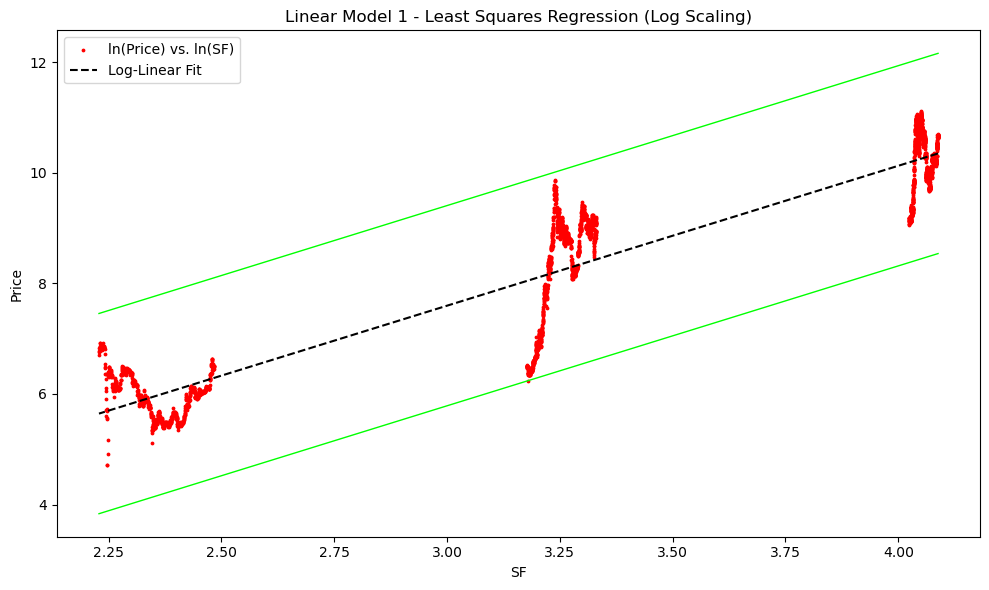

In [9]:
# Plot Bitcoin Price vs. Stock-to-Flow Ratio
y_pred = model.predict(X_const)

# Calculate bounds for least containing stripe
residuals = y_log - y_pred
margin = np.max(np.abs(residuals))
upper_bound = y_pred + margin
lower_bound = y_pred - margin

plt.figure(figsize=(10, 6))
plt.scatter(X_log, y_log, s=3, color='red', label='ln(Price) vs. ln(SF)')
plt.plot(X_log, y_pred, 'k--', label='Log-Linear Fit')
plt.plot(X_log, upper_bound, 'lime', linewidth=1)
plt.plot(X_log, lower_bound, 'lime', linewidth=1)

plt.xlabel('SF')
plt.ylabel('Price')
plt.title(f'Linear Model 1 - Least Squares Regression (Log Scaling)')
plt.legend()
plt.tight_layout()
plt.show()

### N-Fold Cross Validation

In [10]:
kf = KFold(n_splits=5, shuffle=True, random_state=0)

rmse_list = []
r2_list = []
coefs = []

for train_idx, test_idx in kf.split(X_log):
  X_train, X_test = X_log.iloc[train_idx], X_log.iloc[test_idx]
  y_train, y_test = y_log.iloc[train_idx], y_log.iloc[test_idx]

  model_CV = LinearRegression()
  model_CV.fit(X_train, y_train)

  y_pred = model_CV.predict(X_test)

  r2_list.append(r2_score(y_test, y_pred))
  rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))
  coefs.append((model_CV.intercept_, model_CV.coef_[0]))

cv_results = pd.DataFrame({
    'Fold': list(range(1, 6)),
    'R_squared': r2_list,
    'RMSE': rmse_list,
    'Intercept': [c[0] for c in coefs],
    'Slope': [c[1] for c in coefs]
})

r2_mean = cv_results['R_squared'].mean()
rmse_mean = cv_results['RMSE'].mean()

print("Linear Model 1 - Least Squares Model Prediction Performance:")
print(f"R^2 Mean = {r2_mean:.4f}")
print(f"RMSE Mean = {rmse_mean:.4f}")

Linear Model 1 - Least Squares Model Prediction Performance:
R^2 Mean = 0.8612
RMSE Mean = 0.6666


## Model 2 - Polynomial Regression

Linear Model 2 - Polynomial Linear Regression Prediction Performance：
R^2 Mean = 0.8613
RMSE Mean = 0.6661


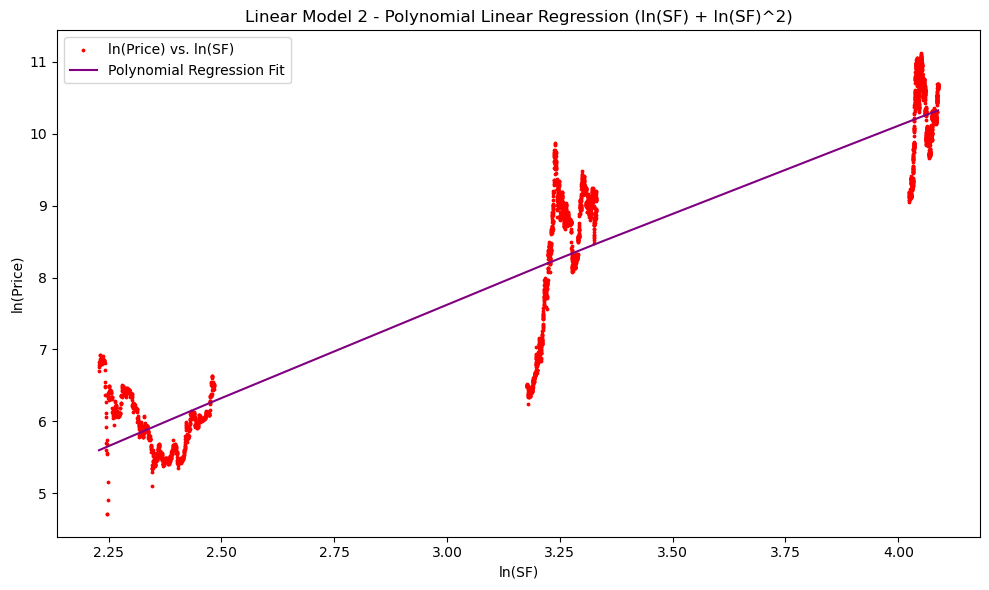

ln(SF): 3.0808
ln(SF)^2: -0.0851
Intercept: -0.8457


In [11]:
# Prepare polynomial features: ln(SF), ln(SF)^2
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_log)  # shape: (n_samples, 2) = [ln(SF), ln(SF)^2]
y = y_log.values

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list = []
r2_list = []

# Initialize linear regression model
model2 = LinearRegression()

# Cross-validation
for train_idx, test_idx in kf.split(X_poly):
    X_train, X_test = X_poly[train_idx], X_poly[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model2.fit(X_train, y_train)
    y_pred = model2.predict(X_test)

    r2_list.append(r2_score(y_test, y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))

# Average performance
r2_mean = np.mean(r2_list)
rmse_mean = np.mean(rmse_list)

print("Linear Model 2 - Polynomial Linear Regression Prediction Performance：")
print(f"R^2 Mean = {r2_mean:.4f}")
print(f"RMSE Mean = {rmse_mean:.4f}")

# Fit the full model for visualization
model2.fit(X_poly, y)
y_pred_poly = model2.predict(X_poly)

# Sort data for smooth plotting
sorted_idx = X_log['ln(SF)'].argsort()
x_plot = X_log.values[sorted_idx]
y_true = y[sorted_idx]
y_pred_plot = y_pred_poly[sorted_idx]

# Plot results
plt.figure(figsize=(10, 6))
plt.scatter(X_log, y_log, s=3, color='red', label='ln(Price) vs. ln(SF)')
plt.plot(x_plot, y_pred_plot, color='purple', label='Polynomial Regression Fit')
plt.xlabel('ln(SF)')
plt.ylabel('ln(Price)')
plt.title('Linear Model 2 - Polynomial Linear Regression (ln(SF) + ln(SF)^2)')
plt.legend()
plt.tight_layout()
plt.show()

# Summary
poly = PolynomialFeatures(degree=2, include_bias=False)
X_poly = poly.fit_transform(X_log)

feature_names = poly.get_feature_names_out(X_log.columns)
for name, coef in zip(feature_names, model2.coef_):
    print(f"{name}: {coef:.4f}")
print(f"Intercept: {model2.intercept_:.4f}")

# Method 2 - Non-Linear Model
- SVR (RBF Kernel)
- Gradient Boosting
- Random Forest

## Model 1 - SVR (RBF Kernel)

In [12]:
# Use the same log-transformed variables from Model 1
X = X_log.values
y = y_log.values

# Create a pipeline with scaler and SVR (scaling improves performance)
pipeline = make_pipeline(StandardScaler(), SVR(kernel='rbf'))

# Define grid search parameter space
param_grid = {
    'svr__C': [1, 10, 100, 1000],
    'svr__gamma': ['scale', 0.01, 0.1, 1],
    'svr__epsilon': [0.01, 0.05, 0.1, 0.5, 0.8, 1]
}

# GridSearchCV setup
grid_search = GridSearchCV(pipeline, param_grid, cv=5, scoring='neg_mean_squared_error', verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X, y)

# Output the best parameters and score
print("Best Parameters:", grid_search.best_params_)


Fitting 5 folds for each of 96 candidates, totalling 480 fits
Best Parameters: {'svr__C': 1, 'svr__epsilon': 0.8, 'svr__gamma': 0.01}


Non-Linear Model 1 - SVR(RBF) Prediction Performance
R^2 Mean = 0.8511
RMSE Mean = 0.6904


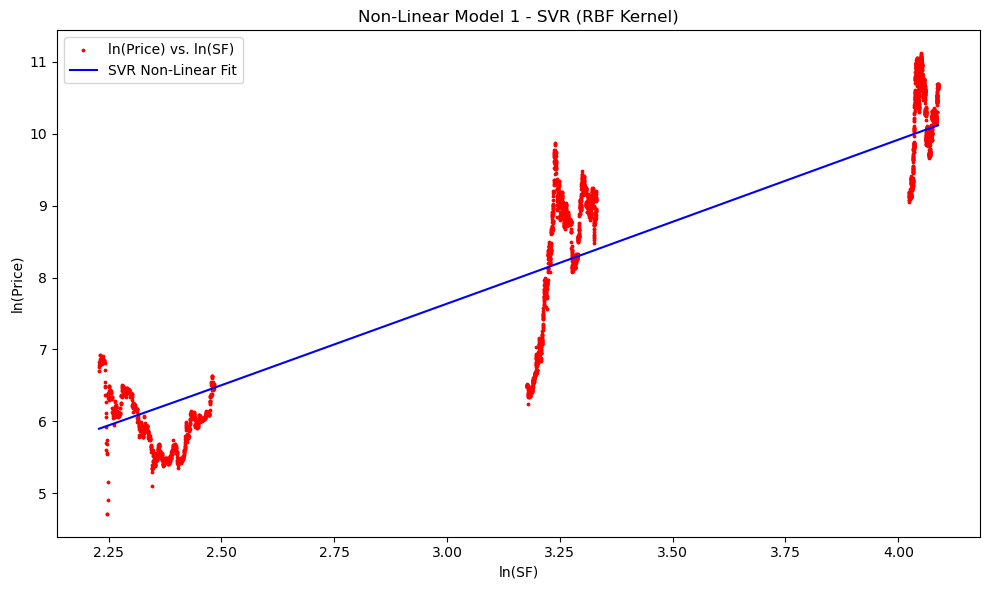

In [13]:
# Non-Linear Model 1 - SVR with RBF Kernel
# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)

rmse_list = []
r2_list = []

# Initialize the SVR model (RBF kernel with default tuned parameters)
model3 = SVR(kernel='rbf', C=1, gamma=0.01, epsilon=0.8)

# Perform cross-validation
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model3.fit(X_train, y_train)
    y_pred = model3.predict(X_test)

    r2_list.append(r2_score(y_test, y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))

# Report average performance across all folds
r2_mean = np.mean(r2_list)
rmse_mean = np.mean(rmse_list)

print("Non-Linear Model 1 - SVR(RBF) Prediction Performance")
print(f"R^2 Mean = {r2_mean:.4f}")
print(f"RMSE Mean = {rmse_mean:.4f}")

# Fit SVR model on the entire dataset for visualization
model3.fit(X, y)
y_pred_svr = model3.predict(X)

# Visualize the SVR non-linear fitting curve
plt.figure(figsize=(10, 6))
plt.scatter(X, y, s=3, color='red', label='ln(Price) vs. ln(SF)')
plt.plot(X, y_pred_svr, color='blue', label='SVR Non-Linear Fit')
plt.xlabel('ln(SF)')
plt.ylabel('ln(Price)')
plt.title('Non-Linear Model 1 - SVR (RBF Kernel)')
plt.legend()
plt.tight_layout()
plt.show()


## Model 2 - Gradient Boosting

In [14]:
# Prepare data
X = X_log.values
y = y_log.values

# Define model and parameter grid
gbr = GradientBoostingRegressor(random_state=42)
param_grid = {
    'n_estimators': [10, 30, 50, 100, 200],
    'max_depth': [1, 2, 3, 4, None],
    'learning_rate': [0.01, 0.05, 0.1]
}

# Grid search with 5-fold cross-validation
grid_search = GridSearchCV(gbr, param_grid, cv=5,
                           scoring='neg_mean_squared_error',
                           verbose=1, n_jobs=-1)

# Fit the model
grid_search.fit(X, y)

# Extract best parameters
best_params = grid_search.best_params_
best_rmse = np.sqrt(-grid_search.best_score_)

print("Best Parameters Found:")
print(best_params)
print(f"Best RMSE (5-fold CV): {best_rmse:.4f}")


Fitting 5 folds for each of 75 candidates, totalling 375 fits
Best Parameters Found:
{'learning_rate': 0.05, 'max_depth': 1, 'n_estimators': 100}
Best RMSE (5-fold CV): 0.7935


Model 5 - Gradient Boosting Regression Performance:
R^2 Mean = 0.9677
RMSE Mean = 0.3219


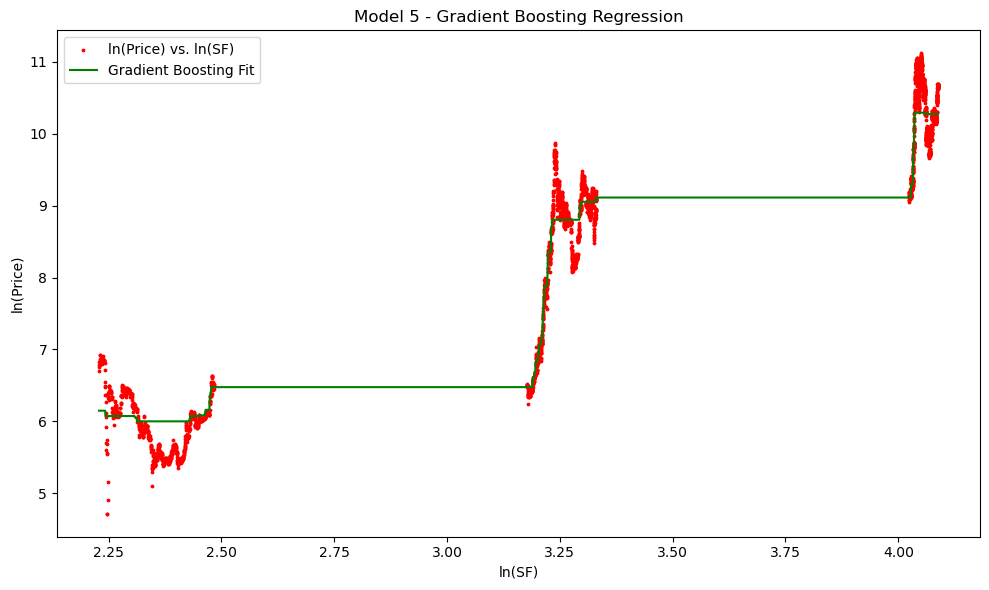

In [15]:
# Use ln(SF) as input, ln(Price) as output
X = X_log.values  # ln(SF)
y = y_log.values  # ln(Price)

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list = []
r2_list = []

# Initialize the Gradient Boosting Regressor
model5 = GradientBoostingRegressor(n_estimators=100, learning_rate=0.05, max_depth=1, random_state=42)

# Cross-validation loop
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model5.fit(X_train, y_train)
    y_pred = model5.predict(X_test)

    r2_list.append(r2_score(y_test, y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))

# Report average performance
r2_mean = np.mean(r2_list)
rmse_mean = np.mean(rmse_list)

print("Model 5 - Gradient Boosting Regression Performance:")
print(f"R^2 Mean = {r2_mean:.4f}")
print(f"RMSE Mean = {rmse_mean:.4f}")

# Fit full model on entire data for visualization
model5.fit(X, y)
y_pred_gb = model5.predict(X)

# Plot the fitting curve
plt.figure(figsize=(10, 6))
plt.scatter(X, y, s=3, color='red', label='ln(Price) vs. ln(SF)')
plt.plot(X, y_pred_gb, color='green', label='Gradient Boosting Fit')
plt.xlabel('ln(SF)')
plt.ylabel('ln(Price)')
plt.title('Model 5 - Gradient Boosting Regression')
plt.legend()
plt.tight_layout()
plt.show()


## Model 3 - Random Forest

In [16]:
# Define RMSE scorer
def rmse_score(y_true, y_pred):
    return -np.sqrt(mean_squared_error(y_true, y_pred))  # negative for GridSearchCV

rmse_scorer = make_scorer(rmse_score)

# Parameter grid
param_grid = {
    'n_estimators': [50, 100, 200],
    'max_depth': [1, 3, 5, 7, None],
    'min_samples_leaf': [1, 3, 5, 10]
}

# Random Forest model
rf_model = RandomForestRegressor(random_state=42)

# Grid search with 5-fold CV
grid_search = GridSearchCV(
    estimator=rf_model,
    param_grid=param_grid,
    cv=5,
    scoring=rmse_scorer,
    verbose=1,
    n_jobs=-1
)

# Fit the grid search
grid_search.fit(X, y)

# Output best parameters and score
best_params = grid_search.best_params_
best_rmse = -grid_search.best_score_

print("Best Parameters for Random Forest:")
print(best_params)
print(f"Best RMSE (5-fold CV): {best_rmse:.4f}")


Fitting 5 folds for each of 60 candidates, totalling 300 fits
Best Parameters for Random Forest:
{'max_depth': 3, 'min_samples_leaf': 1, 'n_estimators': 100}
Best RMSE (5-fold CV): 0.7324


Non-Linear Model 3 - Random Forest Regression Performance:
R^2 Mean = 0.8246
RMSE Mean = 0.7494


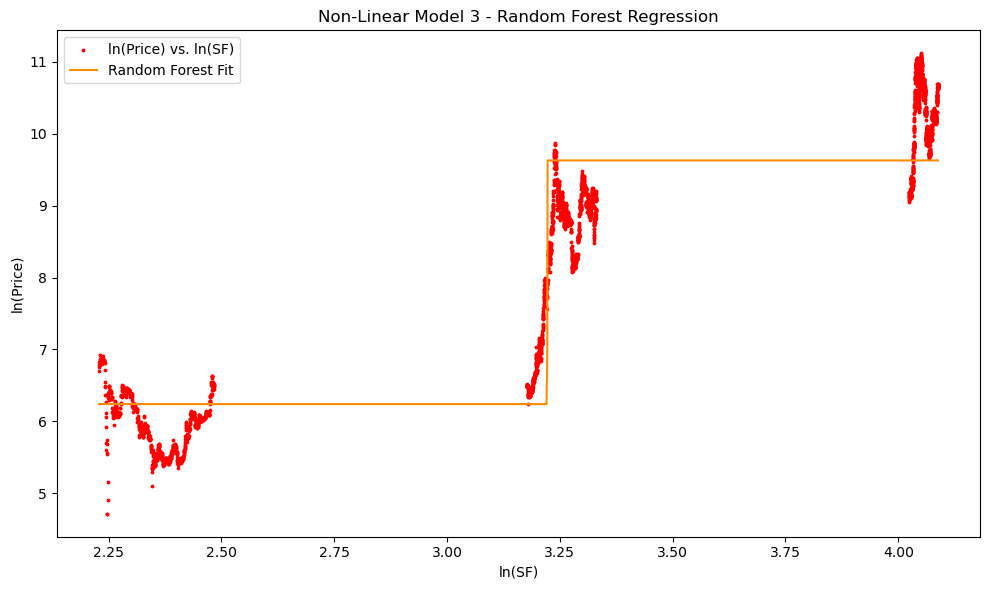

In [17]:
# Feature and target
X = X_log.values  # ln(SF)
y = y_log.values  # ln(Price)

# Initialize 5-fold cross-validation
kf = KFold(n_splits=5, shuffle=True, random_state=42)
rmse_list = []
r2_list = []

# Define the Random Forest model
model_rf = RandomForestRegressor(
    n_estimators=100,
    max_depth=1,            # Control overfitting
    random_state=42,
    min_samples_leaf=1      # More stable splits
)

# Cross-validation loop
for train_idx, test_idx in kf.split(X):
    X_train, X_test = X[train_idx], X[test_idx]
    y_train, y_test = y[train_idx], y[test_idx]

    model_rf.fit(X_train, y_train)
    y_pred = model_rf.predict(X_test)

    r2_list.append(r2_score(y_test, y_pred))
    rmse_list.append(np.sqrt(mean_squared_error(y_test, y_pred)))

# Report average metrics
r2_mean = np.mean(r2_list)
rmse_mean = np.mean(rmse_list)

print("Non-Linear Model 3 - Random Forest Regression Performance:")
print(f"R^2 Mean = {r2_mean:.4f}")
print(f"RMSE Mean = {rmse_mean:.4f}")

# Fit full model for visualization
model_rf.fit(X, y)
y_pred_rf = model_rf.predict(X)

# Visualization
plt.figure(figsize=(10, 6))
plt.scatter(X, y, s=3, color='red', label='ln(Price) vs. ln(SF)')
plt.plot(X, y_pred_rf, color='darkorange', label='Random Forest Fit')
plt.xlabel('ln(SF)')
plt.ylabel('ln(Price)')
plt.title('Non-Linear Model 3 - Random Forest Regression')
plt.legend()
plt.tight_layout()
plt.show()

## Method 3 - Bitcoin close price prediction model using LSTM

## Bitcoin Close Price Prediction Model

Here we aim to predict the closing price of Bitcoin using historical data from 2020-01-01 to 2023-01-01 and a Long Short-Term Memory (LSTM) network implemented with TensorFlow and Keras. The model leverages a sequence of past data points to learn temporal dependencies and forecast future prices.

### Data Preprocessing

1. **Feature Selection & Scaling:**  
   The model reads and selects the necessary columns (Open, High, Low, Close, Adj Close, Volume) from the dataset. A `MinMaxScaler` scales the data into the range [0, 1] to improve the training process.

2. **Sequence Creation:**  
   A sliding window approach is used to convert the time series data into sequences. For example, a window of 60 time steps is created where each sequence is used to predict the next "Close" value.

3. **Train-Test Split:**  
   The available sequences are split into training (80%) and test sets (20%) to evaluate the model's performance.

### Model Architecture

- **LSTM Layer:**  
  A single LSTM layer with 50 units is used to capture temporal dependencies in the data. To force the usage of the generic (non-CuDNN) implementation (avoiding potential GPU-specific issues), small dropout values (e.g., `dropout=0.1` and `recurrent_dropout=0.1`) are set.

- **Dense Layer:**  
  A dense (fully connected) layer with a single unit is used to output the predicted "Close" price. This layer performs regression on the learned representation from the LSTM.

- **Compilation:**  
  The model is compiled with the Adam optimizer and mean-squared error (MSE) as the loss function, which is common for regression tasks.

### Training and Evaluation

- **Training:**  
  The model is trained for 50 epochs using a batch size of 32. The training process monitors performance on both the training and validation (test) datasets.

- **Predictions & Scaling:**  
  After training, predictions on the test set are inverse-transformed back to the original scale (i.e., actual Bitcoin prices) using a helper function.

- **Visualization:**  
  The performance of the model is visualized by plotting the actual versus predicted closing prices, allowing for a visual inspection of the forecasting performance.

### Deployment Considerations

- **GPU Settings:**  
  GPU 0 is explicitly selected for training to leverage hardware acceleration, and care is taken to ensure that the LSTM implementation avoids any unsupported CuDNN kernels by using non-zero dropout values.
- **Scalability:**  
  This approach can be extended to incorporate additional features or more complex LSTM architectures if further improvements in prediction accuracy are desired.

In [18]:
import os
# Specify GPU 0
os.environ["CUDA_VISIBLE_DEVICES"] = "0"

import pandas as pd
import numpy as np
from sklearn.preprocessing import MinMaxScaler
import matplotlib.pyplot as plt
import tensorflow as tf
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import LSTM, Dense

ImportError: Traceback (most recent call last):
  File "C:\Users\Zijun\AppData\Roaming\Python\Python312\site-packages\tensorflow\python\pywrap_tensorflow.py", line 73, in <module>
    from tensorflow.python._pywrap_tensorflow_internal import *
ImportError: DLL load failed while importing _pywrap_tensorflow_internal: 动态链接库(DLL)初始化例程失败。


Failed to load the native TensorFlow runtime.
See https://www.tensorflow.org/install/errors for some common causes and solutions.
If you need help, create an issue at https://github.com/tensorflow/tensorflow/issues and include the entire stack trace above this error message.

In [ ]:
# 1. Load the dataset
df = pd.read_csv("BTC-USD.csv")
# Keep only the specified columns
data = df[['Open', 'High', 'Low', 'Close', 'Adj Close', 'Volume']].values

# 2. Scale the data to [0, 1]
scaler = MinMaxScaler(feature_range=(0, 1))
scaled_data = scaler.fit_transform(data)

# Number of features (6 in this case)
num_features = scaled_data.shape[1]

# 3. Create sequences for LSTM training
# Here we create a sliding window of `time_steps` to predict the "Close" price (column index 3)
time_steps = 60

def create_sequences(data, time_steps):
    X, y = [], []
    for i in range(time_steps, len(data)):
        X.append(data[i-time_steps:i])
        y.append(data[i, 3])  # Target: "Close" price
    return np.array(X), np.array(y)

X, y = create_sequences(scaled_data, time_steps)

# 4. Split data into training and test sets (80% train, 20% test)
train_size = int(len(X) * 0.8)
X_train, X_test = X[:train_size], X[train_size:]
y_train, y_test = y[:train_size], y[train_size:]

# 5. Build the LSTM model
# Setting a small dropout forces TensorFlow to use the generic (non-CuDNN) LSTM kernel.
model = Sequential()
model.add(LSTM(50,
               activation='tanh',
               recurrent_activation='sigmoid',
               dropout=0.1,            # non-zero dropout avoids CuDNN kernel
               recurrent_dropout=0.1,  # non-zero recurrent dropout avoids CuDNN kernel
               input_shape=(time_steps, num_features)))
model.add(Dense(1))
model.compile(optimizer='adam', loss='mean_squared_error')

model.summary()

# 6. Train the model
epochs = 50
batch_size = 32
history = model.fit(X_train, y_train, epochs=epochs, batch_size=batch_size,
                    validation_data=(X_test, y_test))

# 7. Make predictions
predictions = model.predict(X_test)

# 8. Invert scaling to retrieve original price values.
def invert_scale(scaler, data_column, col_index=3):
    dummy = np.zeros((len(data_column), scaler.n_features_in_))
    dummy[:, col_index] = data_column.reshape(-1)
    inverted = scaler.inverse_transform(dummy)[:, col_index]
    return inverted

predicted_close = invert_scale(scaler, predictions.flatten(), col_index=3)
y_test_close = invert_scale(scaler, y_test, col_index=3)

# 9. Plot the results
plt.figure(figsize=(12,6))
plt.plot(y_test_close, label='Actual Close Price')
plt.plot(predicted_close, label='Predicted Close Price')
plt.title("Bitcoin Close Price Prediction Using LSTM (Non-CuDNN)")
plt.xlabel("Time")
plt.ylabel("Price")
plt.legend()
plt.show()
